In [72]:
# each feature has a corresponding importance and sparisity value
# ! this code assigns the same sparisty value to all features !
# also hidden layer has no bias - which the model here does

# essentially does NOT work

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import random
import matplotlib.pyplot as plt
import torch

In [2]:
torch.manual_seed(42)

In [3]:
class SparseDatagen(Dataset):
    def __init__(self, num_samples, vector_length=5, sparsity=0.6):
        assert 0<= sparsity <= 1, "invalid sparsity value [0, 1]"
        self.num_samples = num_samples
        self.vector_length = vector_length
        self.sparsity = sparsity

    def __len__(self):
        return self.num_samples
        
    def __getitem__(self, idx):
        vector = torch.rand(self.vector_length)

        mask = torch.bernoulli(torch.full((self.vector_length,), 1-self.sparsity))
        sparse_vector = vector * mask

        return sparse_vector, sparse_vector


In [4]:
class ToyModel(nn.Module):
    def __init__(self, inp, hid, pre_relu=False):
        super(ToyModel, self).__init__()
        self.pre_relu = pre_relu
        self.enc = nn.Linear(inp, hid)
        self.dec = nn.Linear(hid, inp)

    def forward(self, x):
        x = self.enc(x)
        if self.pre_relu:
            x = F.relu(x)
        x = self.dec(x)
        if not self.pre_relu:
            x = F.relu(x)
        return x

In [81]:
n_in, n_hid = 5, 2

importances = torch.linspace(0.1, 0.9, n_in)
# importances = torch.ones(n_in)
sparse_data = SparseDatagen(num_samples=3000, vector_length=n_in, sparsity=0.00001)
loader = DataLoader(sparse_data, batch_size=32, shuffle=True)

model = ToyModel(inp=n_in, hid=n_hid)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(1):
    for batch_inputs, batch_targets in loader:
        outputs = model(batch_inputs)
        error = importances * (outputs - batch_targets)**2
        loss = error.mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 1, Loss: 0.1119


In [82]:
(importances * (outputs - batch_targets)**2).mean()

tensor(0.1119, grad_fn=<MeanBackward0>)

In [83]:
enc_weights, dec_weights = model.enc.weight.detach().clone().cpu(), model.dec.weight.detach().clone().cpu()

supermat = enc_weights.T @ enc_weights
mask = ~torch.eye(supermat.size(0), dtype=torch.bool)
sim_norm = (supermat * mask).sum(dim=1) 

print(torch.abs(sim_norm).mean(dim=-1))

tensor(0.1870)


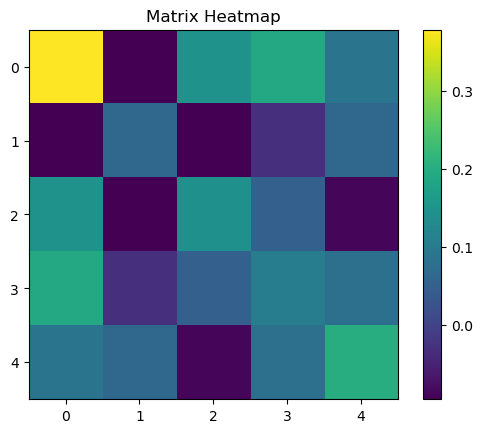

In [84]:
plt.imshow(supermat, cmap='viridis')
plt.colorbar()
plt.title("Matrix Heatmap")
plt.show()